In [1]:
from datetime import datetime

import incense
import matplotlib.pyplot as plt
import numpy as np
from incense import ExperimentLoader


In [2]:
loader = ExperimentLoader(db_name="sacred")


In [3]:
def parse_params(s: str) -> dict:
    """Parse a string of space-separated key=value pairs into a dictionary.

    Example:
        >>> parse_params("a=10 b=1e-4 c=bab | some comment # whatever else")
        {'a': 10, 'b': 0.0001, 'c': 'bab'}
    """
    result = {}
    pairs = s.strip().split()

    for pair in pairs:
        try:
            key, value = pair.split("=")
        except Exception:
            continue
        try:
            value = float(value)
            if value.is_integer():
                value = int(value)
        except ValueError:
            pass
        result[key] = value

    return result


print(parse_params("a=10 b=1e-4 c=bab | some comment # whatever else"))


{'a': 10, 'b': 0.0001, 'c': 'bab'}


In [4]:
from collections import defaultdict
from pprint import pprint

error_lists = defaultdict(list)
loss_lists = defaultdict(list)
names = ["slope-4"]  # , "fixed-steps"]

for exp in loader.find_all():
    notes = exp.meta["comment"]
    if not any(name in notes for name in names):
        continue

    try:
        params = parse_params(notes)
        step = params["step"]
        w = params.get("w", None)
        if params["k"] == "AR":
            w = 1
        elif params["k"] == "D":
            w = 256
        value = min(exp.metrics["q50"])
        loss = min(exp.metrics["loss"])
        error_lists[(step, w)].append(value)
        loss_lists[(step, w)].append(loss)
    except Exception:
        continue


In [5]:
print(str(error_lists)[:100])
print(str(loss_lists)[:100])


defaultdict(<class 'list'>, {(1, 1): [0.01699017360806465, 0.027581356465816498, 0.0332135334610939,
defaultdict(<class 'list'>, {(1, 1): [65.91529719034831, 66.27082915533157, 65.87503729926215, 64.71


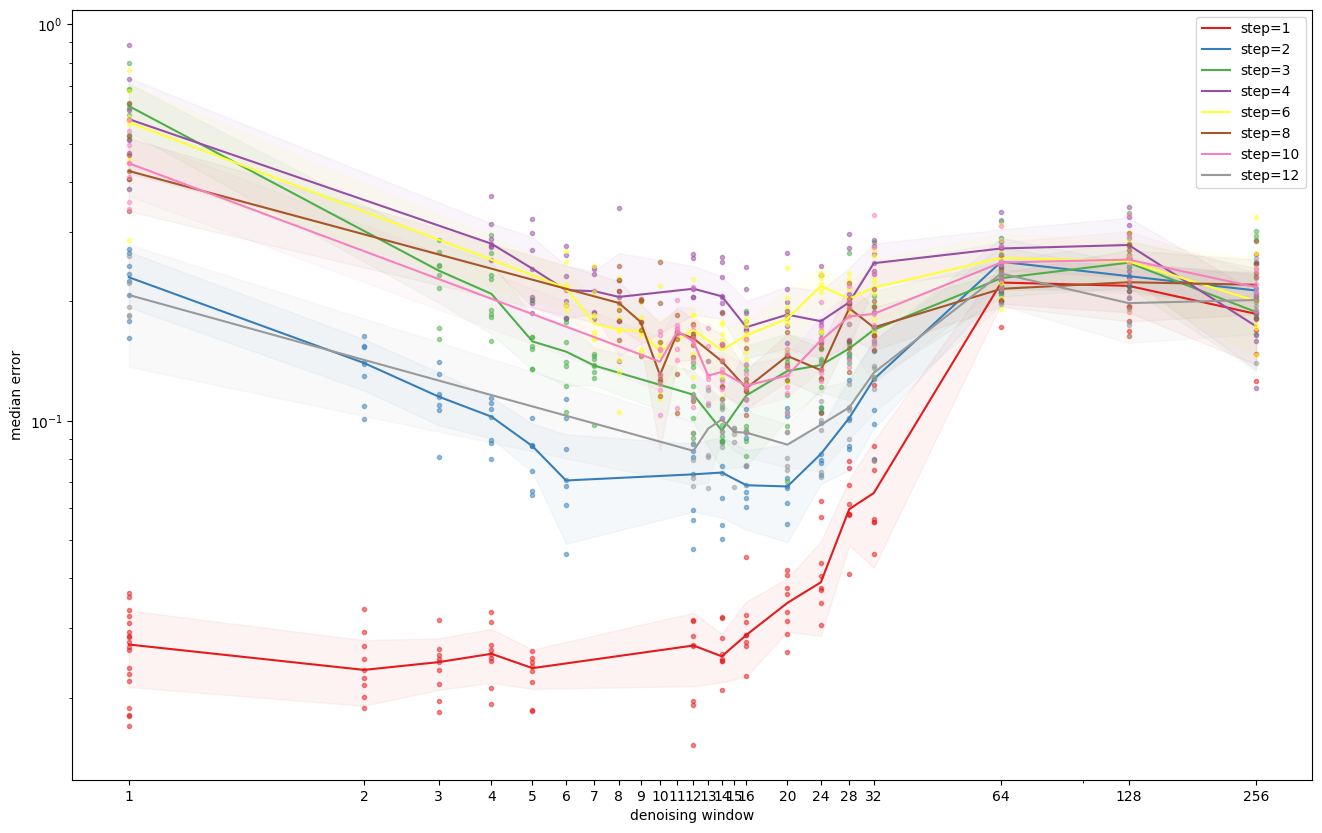

In [14]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(16, 10))
plt.xscale("symlog")
ws = sorted(list(set([w for (step, w) in error_lists])))
steps = sorted(list(set([step for (step, w) in error_lists])))
colors = plt.cm.Set1(np.linspace(0.1, 0.9, len(steps)))

# steps = [6, 8, 10]

for step, color in zip(steps, colors):
    # Collect and compute statistics for each window size
    means, stds, xs = [], [], []
    for w in ws:
        cur = error_lists[(step, w)]
        cur = [x for x in cur if x < 1.0]
        if len(cur) > 0:
            means.append(np.median(cur))
            stds.append(np.std(cur))
            xs.append(w)
            plt.plot([w] * len(cur), cur, "o", ms=3, alpha=0.5, color=color)

    if len(xs) == 0:
        continue

    # Convert to arrays
    means = np.array(means)
    stds = np.array(stds)
    # Smooth means and stds with gaussian filter
    from scipy.ndimage import gaussian_filter1d

    # means = gaussian_filter1d(means, sigma=0.01)
    # stds = gaussian_filter1d(stds, sigma=1.0)
    xs = np.array(xs)

    # Plot mean line and std area
    plt.plot(xs, means, "-", label=f"step={step}", color=color)
    plt.fill_between(xs, means - stds, means + stds, alpha=0.05, color=color)

plt.xticks(ws, [str(w) for w in ws])
plt.xlabel("denoising window")
plt.ylabel("median error")
plt.yscale("log")
plt.legend()
plt.show()


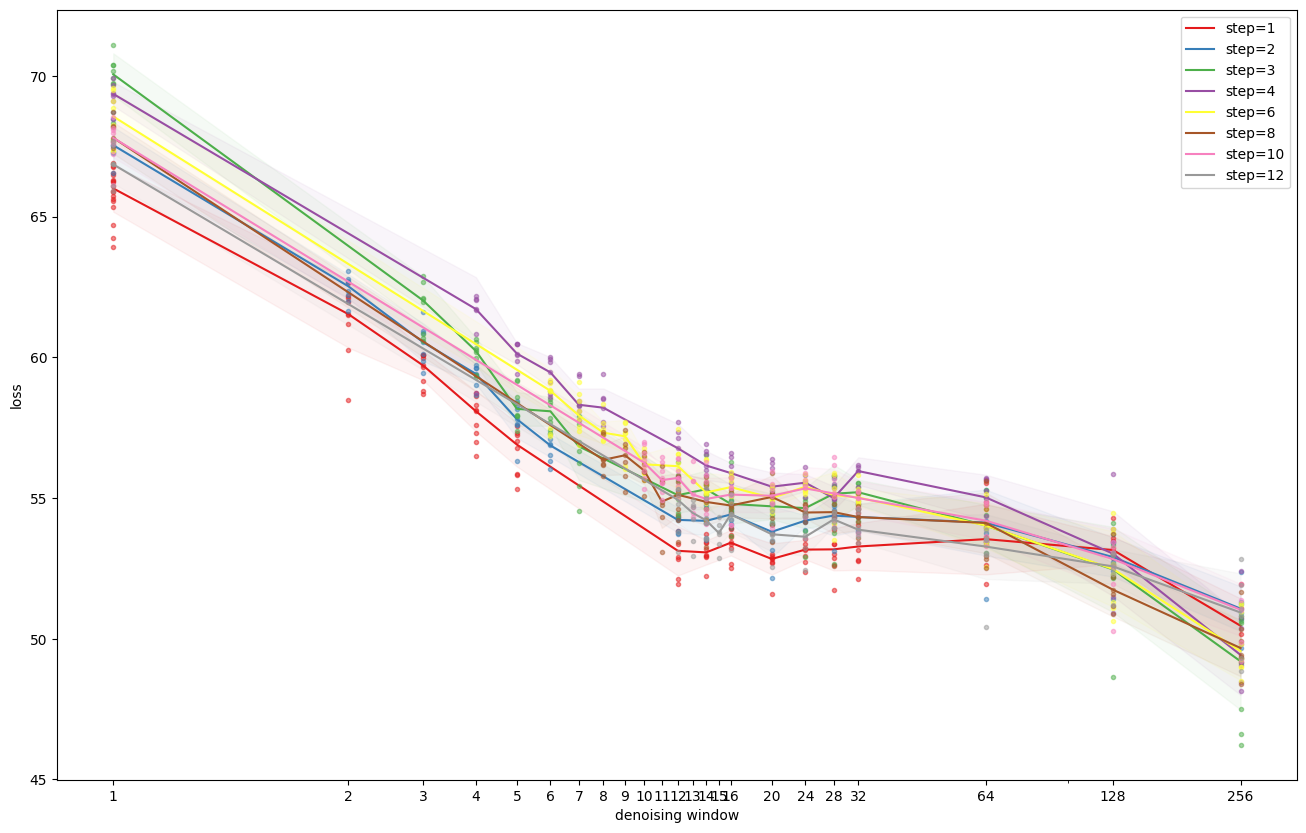

In [13]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(16, 10))
plt.xscale("symlog")
ws = sorted(list(set([w for (step, w) in error_lists])))
steps = sorted(list(set([step for (step, w) in error_lists])))
colors = plt.cm.Set1(np.linspace(0.1, 0.9, len(steps)))


for step, color in zip(steps, colors):
    # Collect and compute statistics for each window size
    means, stds, xs = [], [], []
    for w in ws:
        cur = loss_lists[(step, w)]
        # cur = [x for x in cur if x < 0.6]
        if len(cur) > 0:
            means.append(np.median(cur))
            stds.append(np.std(cur))
            xs.append(w)
            plt.plot([w] * len(cur), cur, "o", ms=3, alpha=0.5, color=color)

    if len(xs) == 0:
        continue

    # Convert to arrays
    means = np.array(means)
    stds = np.array(stds)
    # Smooth means and stds with gaussian filter
    from scipy.ndimage import gaussian_filter1d

    # means = gaussian_filter1d(means, sigma=0.01)
    # stds = gaussian_filter1d(stds, sigma=1.0)
    xs = np.array(xs)

    # Plot mean line and std area
    plt.plot(xs, means, "-", label=f"step={step}", color=color)
    plt.fill_between(xs, means - stds, means + stds, alpha=0.05, color=color)

plt.xticks(ws, [str(w) for w in ws])
plt.xlabel("denoising window")
plt.ylabel("loss")
plt.legend()
plt.show()


1
2
3
4
6
8
10
12


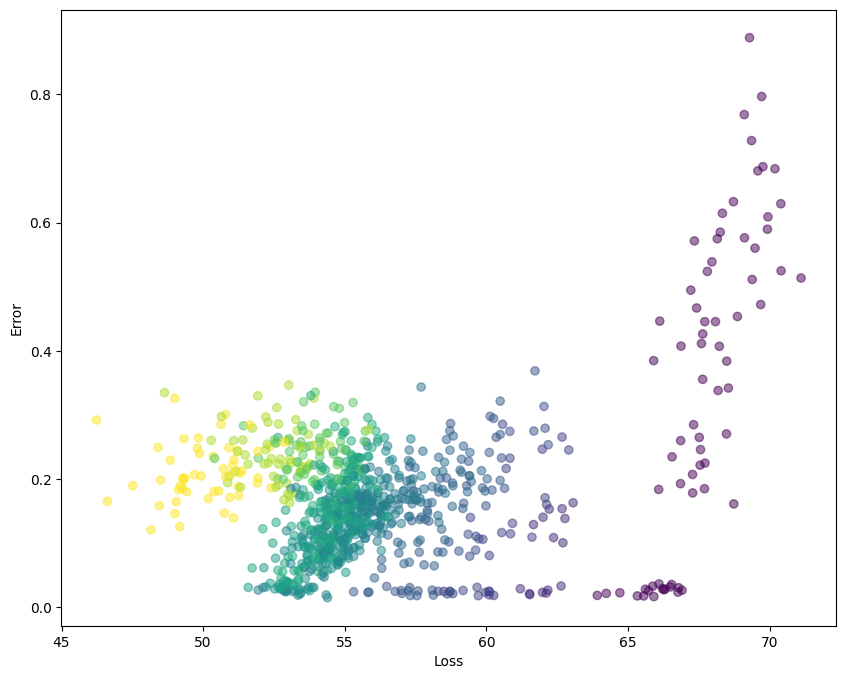

In [8]:
plt.figure(figsize=(10, 8))

# Create scatter plot of loss vs error
for step in steps:
    print(step)
    xs, ys = [], []  # losses and errors
    for w in ws:
        if (step, w) in loss_lists and (step, w) in error_lists:
            losses = loss_lists[(step, w)]
            errors = error_lists[(step, w)]
            if len(losses) == len(errors):
                # Color based on window size w
                color = plt.cm.viridis(np.log(w) / np.log(max(ws)))
                plt.scatter(
                    losses,
                    errors,
                    c=[color] * len(losses),
                    alpha=0.5,
                )

# plt.colorbar()
# plt.yscale("log")
plt.xlabel("Loss")
plt.ylabel("Error")
plt.show()


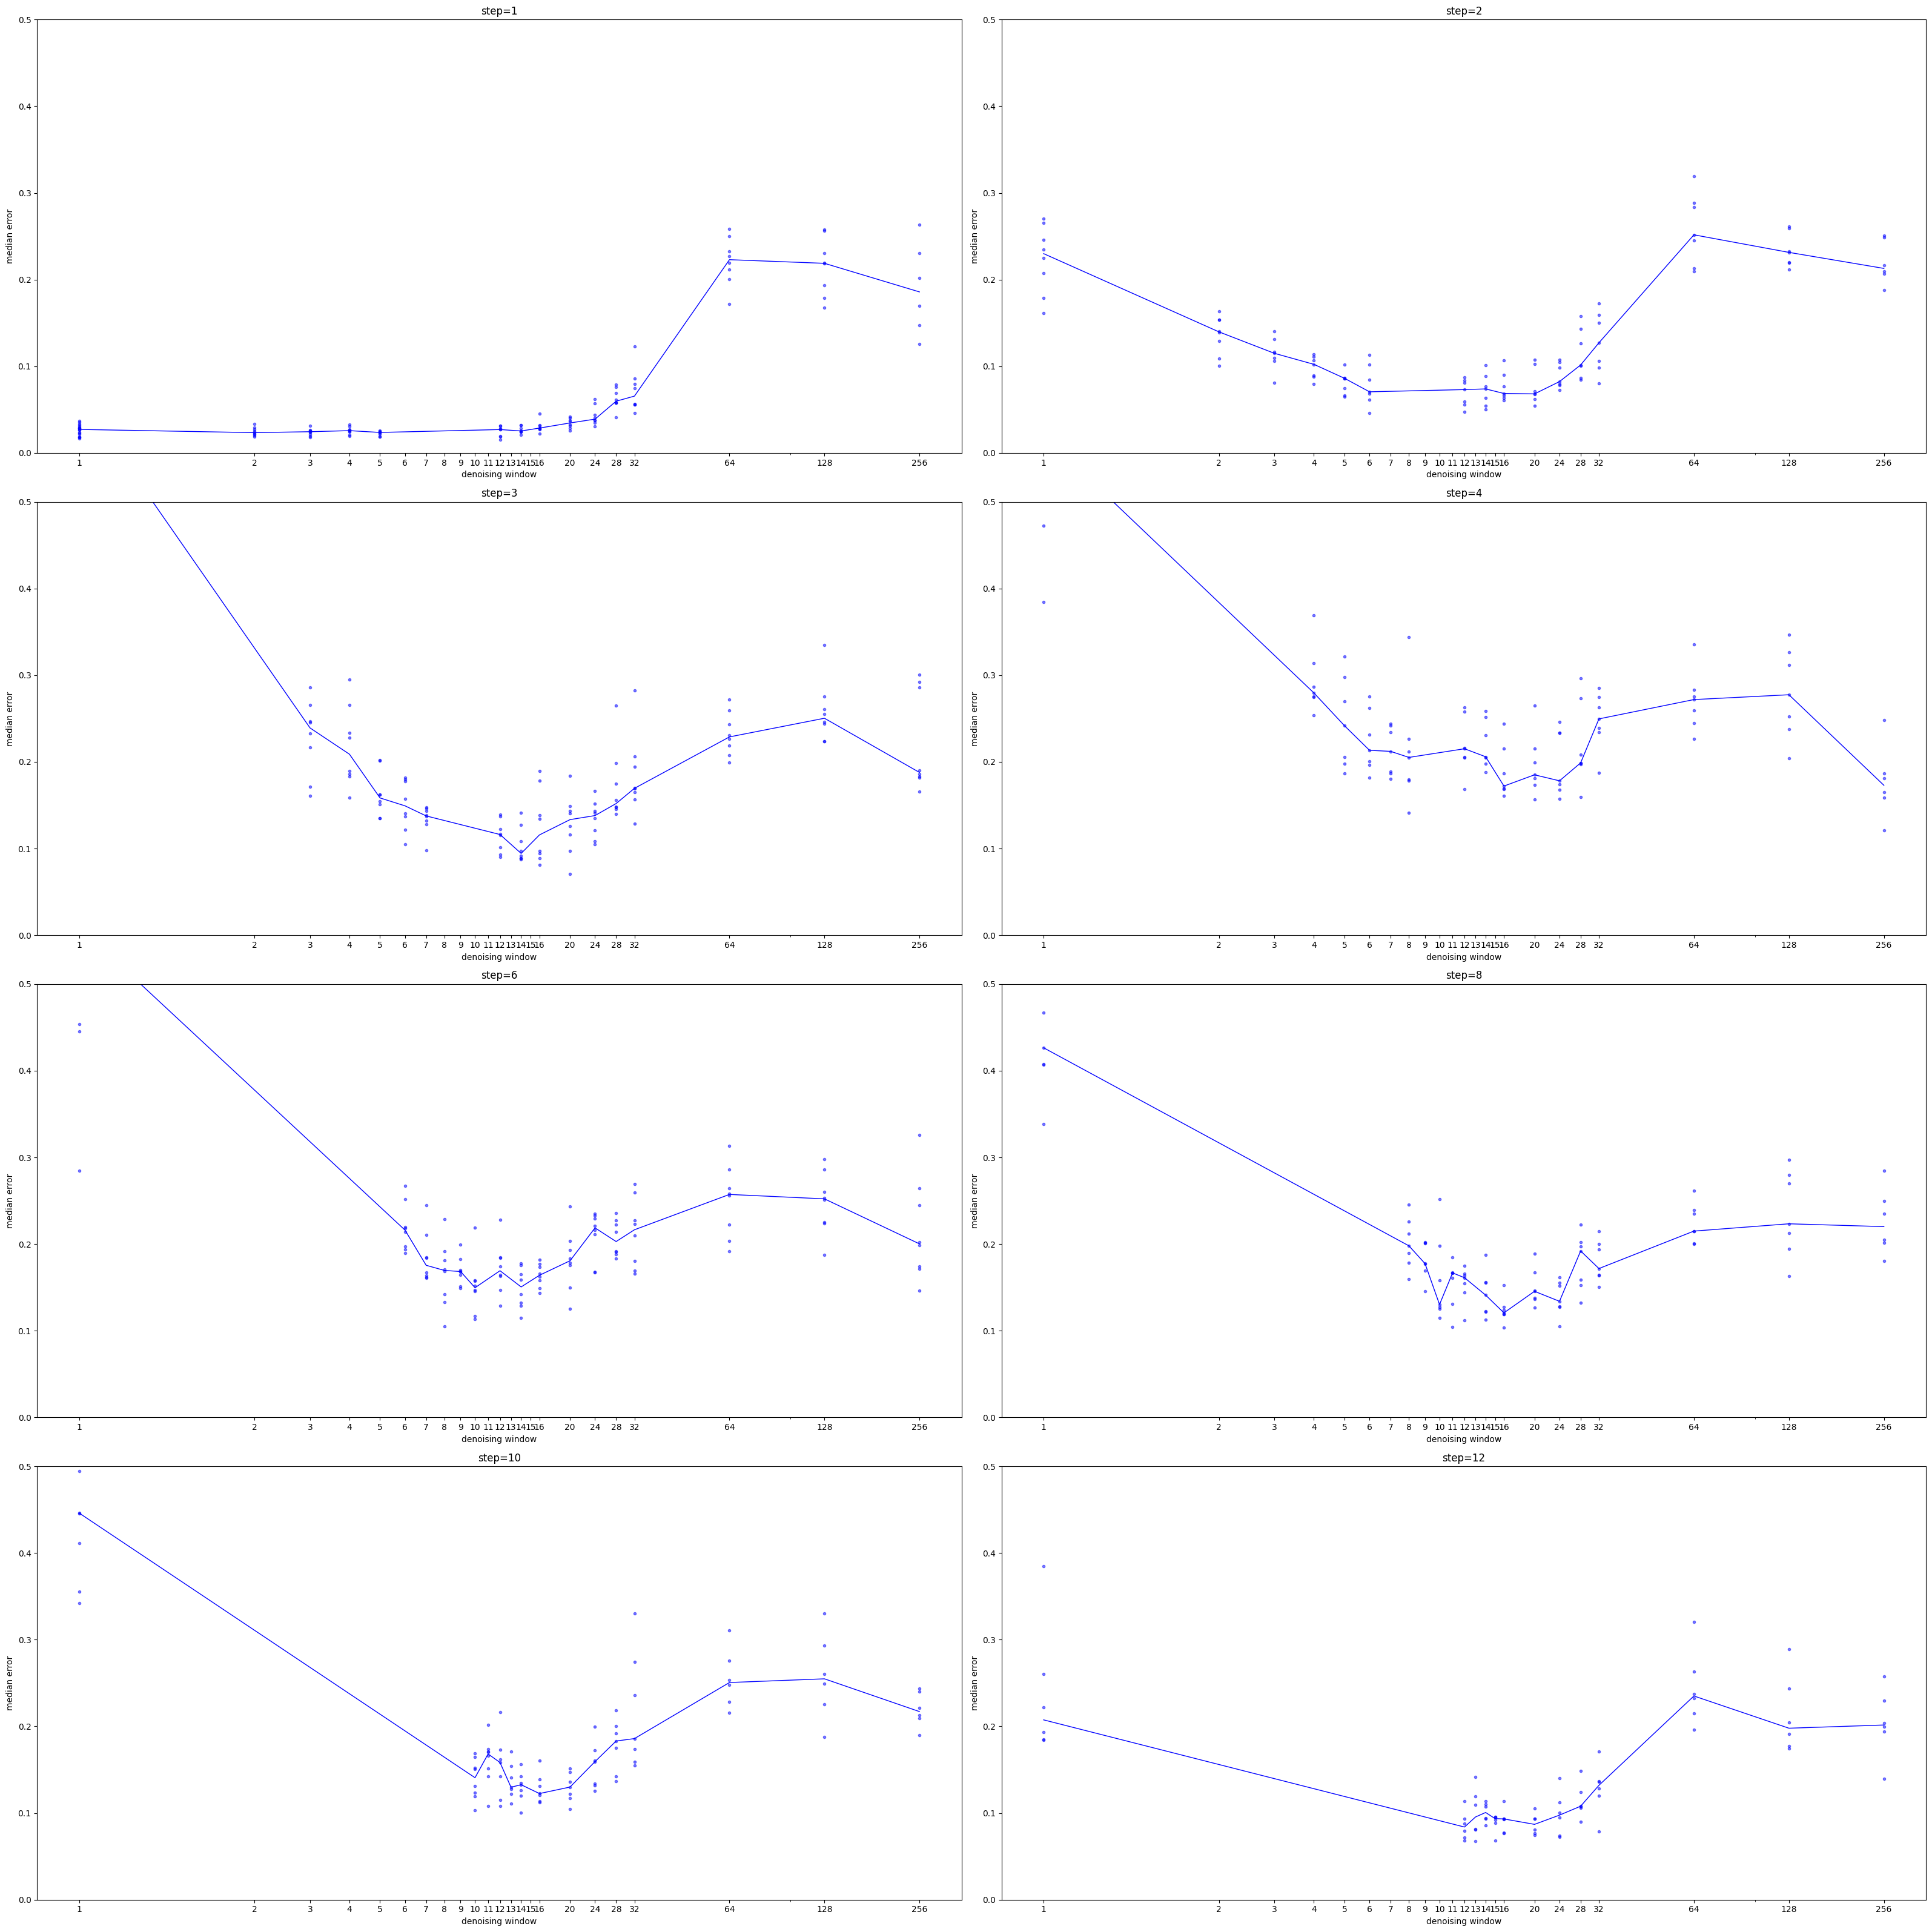

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d

fig, axes = plt.subplots(4, 2, figsize=(32, 32))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
axes = axes.flatten()

ws = sorted(list(set([w for (step, w) in error_lists])))
steps = sorted(list(set([step for (step, w) in error_lists])))
colors = plt.cm.Set1(np.linspace(0.3, 0.7, len(steps)))

for ax, (step, color) in zip(axes, zip(steps, colors)):
    color = "blue"
    ax.set_xscale("symlog")

    # Collect and compute statistics for each window size
    means, stds, xs = [], [], []
    for w in ws:
        cur = error_lists[(step, w)]
        if len(cur) > 0:
            means.append(np.median(cur))
            stds.append(np.std(cur))
            xs.append(w)
            ax.plot([w] * len(cur), cur, "o", ms=3, alpha=0.5, color=color)

    if len(xs) == 0:
        continue

    # Convert to arrays
    means = np.array(means)
    stds = np.array(stds)
    xs = np.array(xs)

    # Smooth means and stds with gaussian filter
    # means = gaussian_filter1d(means, sigma=1.0)
    # stds = gaussian_filter1d(stds, sigma=1.0)

    # Plot mean line and std area
    ax.plot(xs, means, "-", label=f"step={step}", color=color, lw=1)
    # ax.fill_between(xs, means - stds, means + stds, alpha=0.05, color=color)

    ax.set_xticks(ws)
    ax.set_xticklabels([str(w) for w in ws])
    ax.set_title(f"step={step}")
    ax.set_xlabel("denoising window")
    ax.set_ylabel("median error")
    ax.set_ylim(0.0, 0.5)

plt.tight_layout()
plt.show()


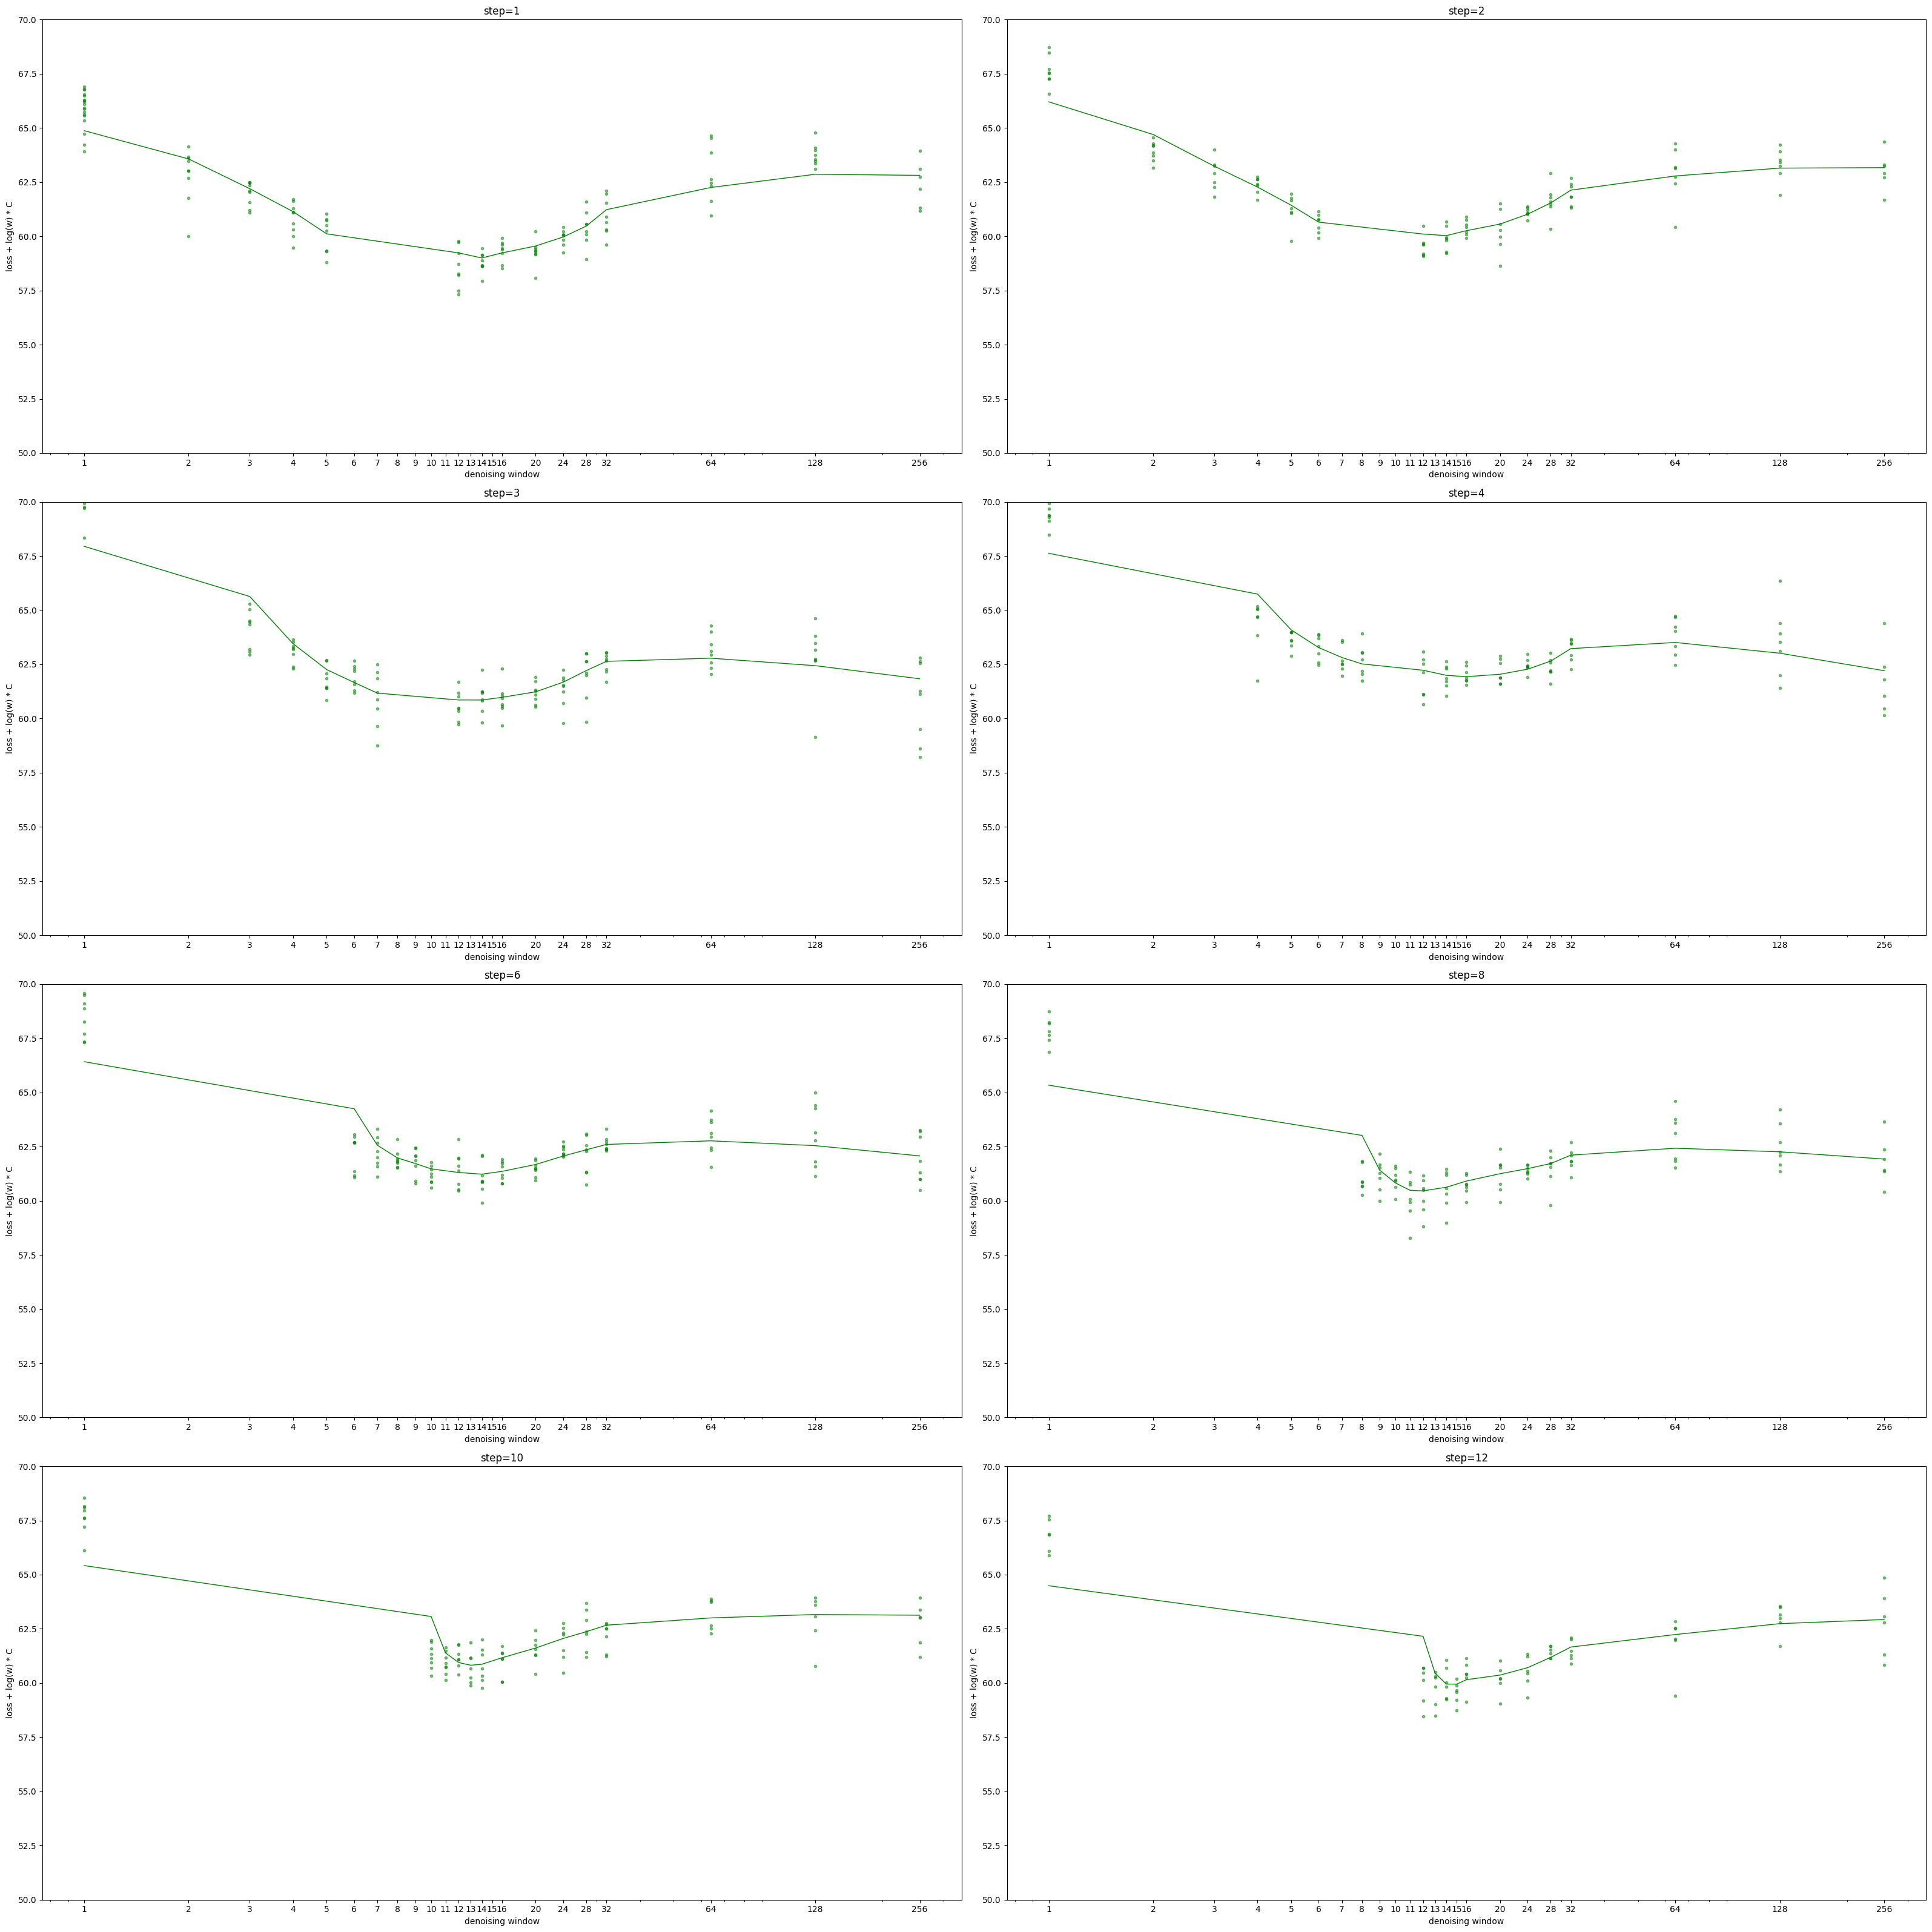

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d

fig, axes = plt.subplots(4, 2, figsize=(32, 32))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
axes = axes.flatten()

ws = sorted(list(set([w for (step, w) in error_lists])))
steps = sorted(list(set([step for (step, w) in error_lists])))
colors = plt.cm.Set1(np.linspace(0.3, 0.7, len(steps)))

for ax, (step, color) in zip(axes, zip(steps, colors)):
    color = "green"
    ax.set_xscale("log")
    C = 12 / np.log(256)

    # Collect and compute statistics for each window size
    means, stds, xs = [], [], []
    for w in ws:
        cur = loss_lists[(step, w)]
        if len(cur) > 0:
            means.append(np.median(cur))
            stds.append(np.std(cur))
            xs.append(w)
            ax.plot(
                [w] * len(cur), cur + np.log(w) * C, "o", ms=3, alpha=0.5, color=color
            )

    if len(xs) == 0:
        continue

    # Convert to arrays
    xs = np.array(xs)
    correction = np.log(xs) * C
    means = np.array(means) + correction
    stds = np.array(stds)

    # Smooth means and stds with gaussian filter
    means = gaussian_filter1d(means, sigma=1.0)
    stds = gaussian_filter1d(stds, sigma=1.0)

    # Plot mean line and std area
    ax.plot(xs, means, "-", label=f"step={step}", color=color, lw=1)
    # ax.fill_between(xs, means - stds, means + stds, alpha=0.05, color=color)

    ax.set_xticks(ws)
    ax.set_xticklabels([str(w) for w in ws])
    ax.set_title(f"step={step}")
    ax.set_xlabel("denoising window")
    ax.set_ylabel("loss + log(w) * C")
    ax.set_ylim(50.0, 70.0)

plt.tight_layout()
plt.show()


/Users/mike/Desktop/gud/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter kernel__length_scale is close to the specified lower bound 5.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/mike/Desktop/gud/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter kernel__length_scale is close to the specified lower bound 5.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/mike/Desktop/gud/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter kernel__length_scale is close to the specified lower bound 5.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


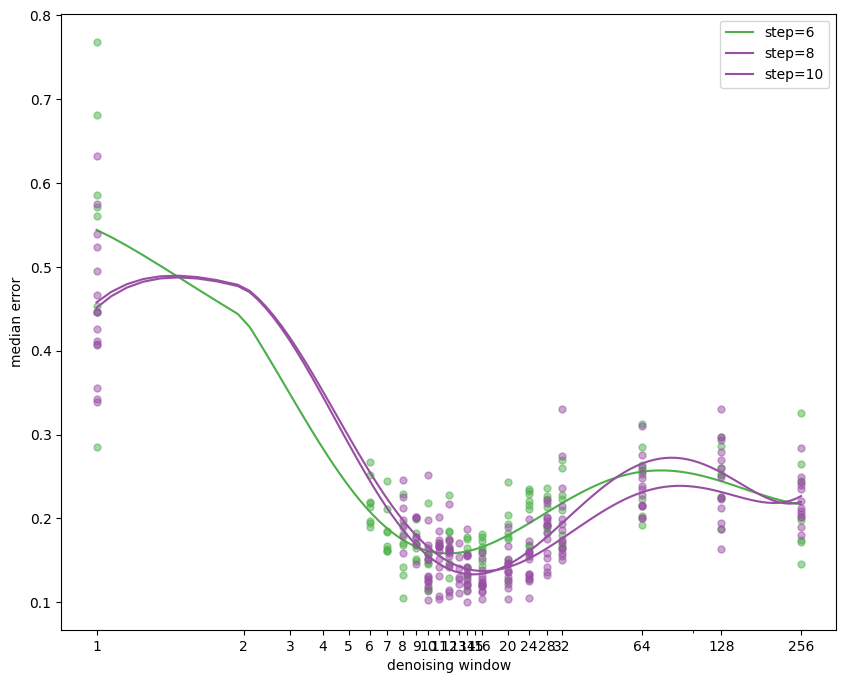

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

plt.figure(figsize=(10, 8))
plt.xscale("symlog")
ws = sorted(list(set([w for (step, w) in error_lists])))
steps = sorted(list(set([step for (step, w) in error_lists])))
colors = plt.cm.Set1(np.linspace(0.3, 0.7, len(steps)))
steps = [6, 8, 10]

for step, color in zip(steps, colors):
    # Collect data points for each window size
    points_x, points_y = [], []
    for w in ws:
        cur = error_lists[(step, w)]
        cur = [x for x in cur if x < 2]
        if len(cur) > 0:
            points_x.extend([np.log1p(w)] * len(cur))
            points_y.extend(cur)
            plt.plot([w] * len(cur), cur, "o", ms=5, alpha=0.5, color=color)

    if len(points_x) == 0:
        continue

    # Convert to arrays and reshape for GP
    X = np.array(points_x).reshape(-1, 1)
    y = np.array(points_y)

    # Define kernel as sum of RBF and WhiteNoise
    l, r = 5.0, 10.0
    kernel = (
        RBF(length_scale=(l * r) ** 0.5, length_scale_bounds=(l, r)) ** 0.5
    )  # + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-10, 1.0))

    # Fit Gaussian Process
    gp = GaussianProcessRegressor(kernel=kernel, random_state=0)
    gp.fit(X, y)

    # Predict on fine grid for smooth curve
    X_pred = np.linspace(np.log1p(min(ws)), np.log1p(max(ws)), 100).reshape(-1, 1)
    y_pred, sigma = gp.predict(X_pred, return_std=True)

    # Plot GP mean and confidence interval
    plt.plot(np.expm1(X_pred), y_pred, "-", label=f"step={step}", color=color)
    plt.fill_between(
        np.expm1(X_pred).ravel(),
        y_pred - 2 * sigma,
        y_pred + 2 * sigma,
        alpha=0.05,
        color=color,
    )

plt.xticks(ws, [str(w) for w in ws])
plt.xlabel("denoising window")
plt.ylabel("median error")
plt.legend()
plt.show()
